Predict next 144 blocks

Epoch [1/50], Loss: 7.4256
Epoch [2/50], Loss: 3.3439
Epoch [3/50], Loss: 3.3356
Epoch [4/50], Loss: 3.3221
Epoch [5/50], Loss: 3.3005
Epoch [6/50], Loss: 3.2629
Epoch [7/50], Loss: 3.1822
Epoch [8/50], Loss: 3.1019
Epoch [9/50], Loss: 2.9810
Epoch [10/50], Loss: 2.8778
Epoch [11/50], Loss: 2.8482
Epoch [12/50], Loss: 2.8138
Epoch [13/50], Loss: 2.7546
Epoch [14/50], Loss: 2.7500
Epoch [15/50], Loss: 2.7351
Epoch [16/50], Loss: 2.7327
Epoch [17/50], Loss: 2.8016
Epoch [18/50], Loss: 2.7375
Epoch [19/50], Loss: 2.7248
Epoch [20/50], Loss: 2.7215
Epoch [21/50], Loss: 2.7668
Epoch [22/50], Loss: 2.7723
Epoch [23/50], Loss: 2.7338
Epoch [24/50], Loss: 2.7107
Epoch [25/50], Loss: 2.7077
Epoch [26/50], Loss: 2.7046
Epoch [27/50], Loss: 2.7277
Epoch [28/50], Loss: 2.7165
Epoch [29/50], Loss: 2.7771
Epoch [30/50], Loss: 2.7117
Epoch [31/50], Loss: 2.7198
Epoch [32/50], Loss: 2.7539
Epoch [33/50], Loss: 2.7022
Epoch [34/50], Loss: 2.7016
Epoch [35/50], Loss: 2.6945
Epoch [36/50], Loss: 2.6898
E

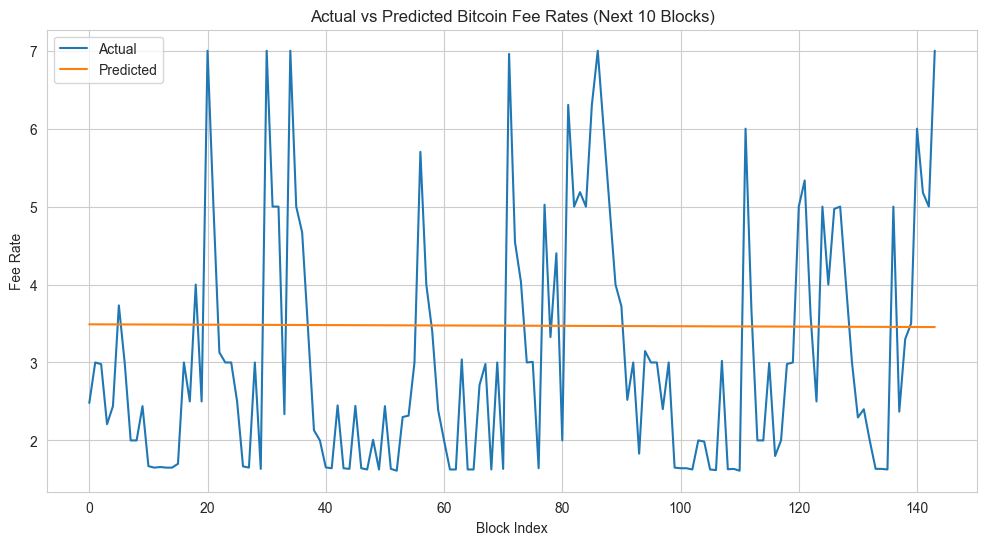


Prophet Model Performance for Next 144 Blocks:
Mean Absolute Error: 1.3503
Mean Squared Error: 2.4213
Root Mean Squared Error: 1.5560
R-squared Score: -0.061846884671078906
MAPE: 54.3713%
Directional Accuracy: 55.2448%
Theil's U Statistic: 0.5205
Training time: 500.4234871864319s


In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)
start=time.time()

# Load and preprocess data
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

df=df[:-144]

# Separate features into categories
historical_features = [
    'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
    'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_weight', 'block_interval', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity',
    'hash_rate', 'bitcoin_price_usd'
]

known_future_features = ['block_height', 'difficulty', 'block_version']

all_features = historical_features + known_future_features

# Scaling features
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df[all_features])

target = 'block_median_fee_rate'
max_encoder_length = 288 # Past 288 observations (48 hours)
max_prediction_length = 144  # Predict next 144 blocks (approximately 24 hours)

# Time2Vec layer
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x):
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

# Define custom dataset
class Time2VecDataset(Dataset):
    def __init__(self, data, historical_features, future_known_features, target, max_encoder_length, max_prediction_length):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.max_encoder_length = max_encoder_length
        self.max_prediction_length = max_prediction_length

    def __len__(self):
        return len(self.data) - self.max_encoder_length - self.max_prediction_length + 1

    def __getitem__(self, idx):
        encoder_start = idx
        encoder_end = idx + self.max_encoder_length
        decoder_end = encoder_end + self.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        # Create time feature (assuming each step is 10 minutes apart)
        time_feature = torch.arange(0, self.max_encoder_length, dtype=torch.float32).unsqueeze(1)

        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

# Create dataset and dataloaders
dataset = Time2VecDataset(df, historical_features, known_future_features, target, max_encoder_length, max_prediction_length)
batch_size = 32#32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# BitcoinFeeModel class remains the same as 10 blocks
class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + time2vec_dim, hidden_dim, batch_first=True)
        self.fc_combine = nn.Linear(hidden_dim + future_input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.num_predictions = num_predictions

    def forward(self, time_feature, x_hist, x_future):
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)
# Model parameters
hist_input_dim = len(historical_features)
future_known_dim = len(known_future_features)
time2vec_dim = 20 #20
hidden_dim = 128 # 128
output_dim = 1
num_predictions = max_prediction_length

# Instantiate model, loss function, and optimizer
model = BitcoinFeeModel(hist_input_dim, future_known_dim, time2vec_dim, hidden_dim, output_dim, num_predictions)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)  # 0.0002

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50  # Increased number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for time_feature, x_hist, x_future_known, y in train_dataloader:
        time_feature, x_hist, x_future_known, y = time_feature.to(device), x_hist.to(device), x_future_known.to(device), y.to(device)

        # Forward pass
        outputs = model(time_feature, x_hist, x_future_known)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Make future predictions
def predict_future(model, data, historical_features, known_future_features, max_encoder_length, max_prediction_length):
    model.eval()
    hist_data = data.tail(max_encoder_length)[historical_features].values
    last_block_height = data['block_height'].iloc[-1]
    last_difficulty = data['difficulty'].iloc[-1]
    last_block_version = data['block_version'].iloc[-1]
    
    future_known_data = np.zeros((max_prediction_length, len(known_future_features)))
    for i in range(max_prediction_length):
        future_known_data[i] = [last_block_height + i + 1, last_difficulty, last_block_version]
    
    time_feature = torch.arange(0, max_encoder_length, dtype=torch.float32).unsqueeze(1).to(device)
    x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(device)
    x_future_known = torch.tensor(future_known_data, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(time_feature, x_hist, x_future_known).cpu().numpy().flatten()

    return predictions

# Predict next 144 blocks
future_predictions = predict_future(model, df, historical_features, known_future_features, max_encoder_length, max_prediction_length)
end=time.time()

df = pd.read_csv('real_time_cleaned.csv')
# Plot results
plt.figure(figsize=(12, 6))
y_true = df[target].iloc[-max_prediction_length:].values
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(future_predictions)), future_predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 10 Blocks)')
plt.xlabel('Block Index')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(y_true, future_predictions)
mse = mean_squared_error(y_true, future_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, future_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator


mape = mean_absolute_percentage_error(y_true, future_predictions)
da = directional_accuracy(y_true, future_predictions)
theils_u = theil_u(y_true, future_predictions)
end=time.time()

print("\nProphet Model Performance for Next 144 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start}s")

In [11]:
future_predictions

array([3.489601 , 3.4893548, 3.4891088, 3.4888632, 3.4886167, 3.488371 ,
       3.4881248, 3.487879 , 3.487633 , 3.487387 , 3.487141 , 3.486895 ,
       3.4866488, 3.4864028, 3.486157 , 3.4859111, 3.485665 , 3.485419 ,
       3.485173 , 3.4849272, 3.4846811, 3.484435 , 3.484189 , 3.4839432,
       3.4836972, 3.4834514, 3.483205 , 3.4829593, 3.4827132, 3.482467 ,
       3.4822211, 3.4819753, 3.481729 , 3.481483 , 3.4812367, 3.480991 ,
       3.480745 , 3.480499 , 3.4802532, 3.4800076, 3.479761 , 3.4795153,
       3.479269 , 3.479023 , 3.478777 , 3.4785311, 3.4782853, 3.4780393,
       3.477793 , 3.477547 , 3.477301 , 3.4770548, 3.4768088, 3.4765632,
       3.476317 , 3.476071 , 3.4758258, 3.475579 , 3.475333 , 3.4750872,
       3.4748414, 3.4745958, 3.4743493, 3.4741027, 3.4738572, 3.4736114,
       3.4733655, 3.4731195, 3.4728732, 3.4726272, 3.4723814, 3.4721358,
       3.4718895, 3.4716434, 3.4713972, 3.4711518, 3.4709053, 3.4706597,
       3.4704134, 3.4701674, 3.4699209, 3.4696758, 

Ignore following code cells, they are for cross validation and drop out layer

[I 2024-10-13 19:29:16,947] A new study created in memory with name: no-name-9fe43522-a408-4124-9d37-ac8987d83b7a
/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_95917/422053060.py:119: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 19:35:41,869] Trial 0 finished with value: 5.514817237854004 and parameters: {'time2vec_dim': 9, 'hidden_dim': 99, 'num_lstm_layers': 2, 'dropout': 0.27473535186940595, 'learning_rate': 0.002238587627232479, 'batch_size': 16}. Best is trial 0 with value: 5.514817237854004.
/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_95917/422053060.py:119: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Best trial:
Value:  3.9314510822296143
Params: 
    time2vec_dim: 20
    hidden_dim: 137
    num_lstm_layers: 1
    dropout: 0.31485799115909086
    learning_rate: 0.0002835014869194438
    batch_size: 128
Epoch [1/50], Loss: 12.5352
Epoch [2/50], Loss: 5.8639
Epoch [3/50], Loss: 3.4021
Epoch [4/50], Loss: 3.3229
Epoch [5/50], Loss: 3.3100
Epoch [6/50], Loss: 3.3064
Epoch [7/50], Loss: 3.3061
Epoch [8/50], Loss: 3.2955
Epoch [9/50], Loss: 3.2978
Epoch [10/50], Loss: 3.2975
Epoch [11/50], Loss: 3.2919
Epoch [12/50], Loss: 3.2957
Epoch [13/50], Loss: 3.2898
Epoch [14/50], Loss: 3.2866
Epoch [15/50], Loss: 3.2877
Epoch [16/50], Loss: 3.2887
Epoch [17/50], Loss: 3.2778
Epoch [18/50], Loss: 3.2755
Epoch [19/50], Loss: 3.2692
Epoch [20/50], Loss: 3.2686
Epoch [21/50], Loss: 3.2600
Epoch [22/50], Loss: 3.2572
Epoch [23/50], Loss: 3.2455
Epoch [24/50], Loss: 3.2410
Epoch [25/50], Loss: 3.2315
Epoch [26/50], Loss: 3.2262
Epoch [27/50], Loss: 3.2166
Epoch [28/50], Loss: 3.2093
Epoch [29/50], Los

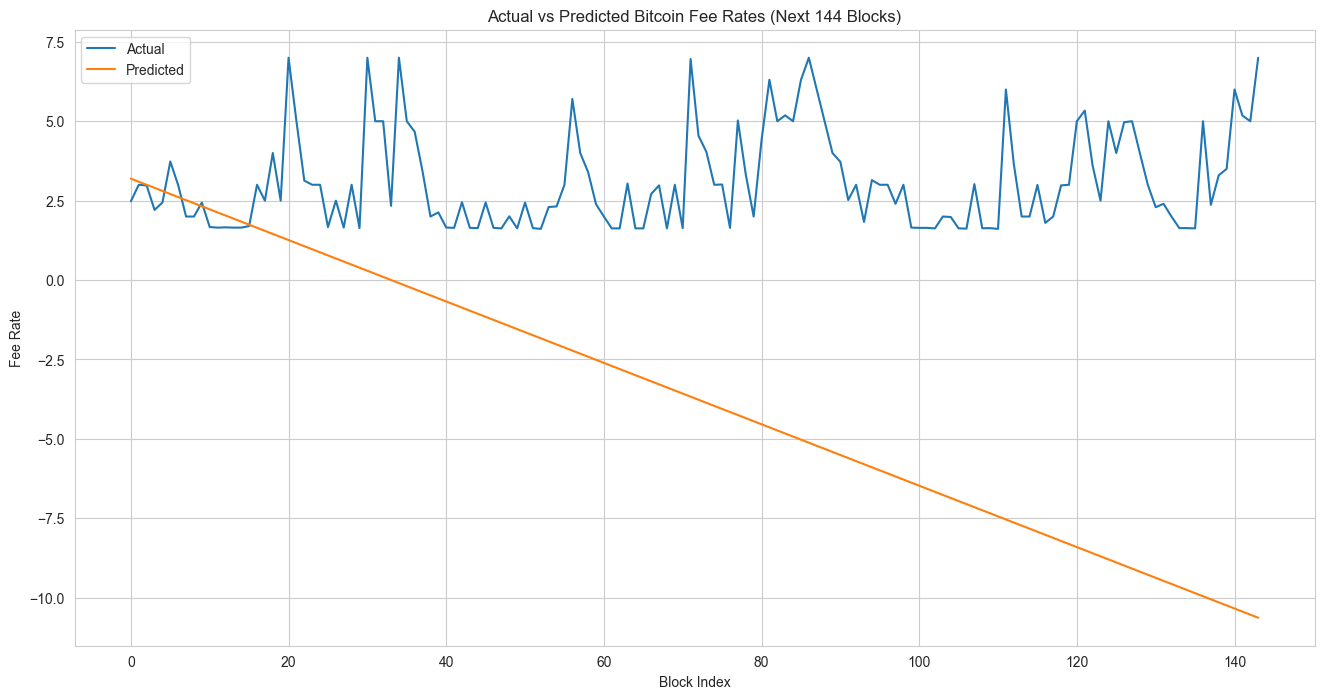


Prophet Model Performance for Next 10 Blocks:
Mean Absolute Error: 6.8888
Mean Squared Error: 66.9189
Root Mean Squared Error: 8.1804
R-squared Score: -28.347494170095004
MAPE: 240.4026%
Directional Accuracy: 53.8462%
Theil's U Statistic: 0.8802


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optuna

# Load and preprocess data
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Separate features into categories
historical_features = [
    'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
    'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_weight', 'block_interval', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity',
    'hash_rate', 'bitcoin_price_usd'
]

known_future_features = ['block_height', 'difficulty', 'block_version']

all_features = historical_features + known_future_features

# Scaling features
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df[all_features])

target = 'block_median_fee_rate'
max_encoder_length = 288  # Past 288 observations (48 hours)
max_prediction_length = 144  # Predict next 144 blocks (approximately 24 hours)

# Time2Vec layer
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x):
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

# Define custom dataset
class Time2VecDataset(Dataset):
    def __init__(self, data, historical_features, future_known_features, target, max_encoder_length, max_prediction_length):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.max_encoder_length = max_encoder_length
        self.max_prediction_length = max_prediction_length

    def __len__(self):
        return len(self.data) - self.max_encoder_length - self.max_prediction_length + 1

    def __getitem__(self, idx):
        encoder_start = idx
        encoder_end = idx + self.max_encoder_length
        decoder_end = encoder_end + self.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        time_feature = torch.arange(0, self.max_encoder_length, dtype=torch.float32).unsqueeze(1)

        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

# Define the model
class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions, num_lstm_layers, dropout):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + time2vec_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True, dropout=dropout)
        self.fc_combine = nn.Linear(hidden_dim + future_input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.num_predictions = num_predictions

    def forward(self, time_feature, x_hist, x_future):
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n[-1]
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)

# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    time2vec_dim = trial.suggest_int('time2vec_dim', 8, 32)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    num_lstm_layers = trial.suggest_int('num_lstm_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create model
    model = BitcoinFeeModel(
        hist_input_dim=len(historical_features),
        future_input_dim=len(known_future_features),
        time2vec_dim=time2vec_dim,
        hidden_dim=hidden_dim,
        output_dim=1,
        num_predictions=max_prediction_length,
        num_lstm_layers=num_lstm_layers,
        dropout=dropout
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []

    for train_index, val_index in tscv.split(df):
        train_data = df.iloc[train_index]
        val_data = df.iloc[val_index]

        train_dataset = Time2VecDataset(train_data, historical_features, known_future_features, target, max_encoder_length, max_prediction_length)
        val_dataset = Time2VecDataset(val_data, historical_features, known_future_features, target, max_encoder_length, max_prediction_length)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        for epoch in range(10):  # Reduced number of epochs for faster trials
            model.train()
            for time_feature, x_hist, x_future, y in train_loader:
                time_feature, x_hist, x_future, y = time_feature.to(device), x_hist.to(device), x_future.to(device), y.to(device)

                optimizer.zero_grad()
                outputs = model(time_feature, x_hist, x_future)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

        model.eval()
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for time_feature, x_hist, x_future, y in val_loader:
                time_feature, x_hist, x_future, y = time_feature.to(device), x_hist.to(device), x_future.to(device), y.to(device)
                outputs = model(time_feature, x_hist, x_future)
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(y.cpu().numpy())

        mse = mean_squared_error(val_targets, val_predictions)
        cv_scores.append(mse)

    return np.mean(cv_scores)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best parameters
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Train the final model with the best hyperparameters
best_params = study.best_params
best_model = BitcoinFeeModel(
    hist_input_dim=len(historical_features),
    future_input_dim=len(known_future_features),
    time2vec_dim=best_params['time2vec_dim'],
    hidden_dim=best_params['hidden_dim'],
    output_dim=1,
    num_predictions=max_prediction_length,
    num_lstm_layers=best_params['num_lstm_layers'],
    dropout=best_params['dropout']
)

# Create full dataset and dataloader
full_dataset = Time2VecDataset(df, historical_features, known_future_features, target, max_encoder_length, max_prediction_length)
full_dataloader = DataLoader(full_dataset, batch_size=best_params['batch_size'], shuffle=True, drop_last=True)

# Train the best model on the full dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

num_epochs = 50  # You can adjust this
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for time_feature, x_hist, x_future, y in full_dataloader:
        time_feature, x_hist, x_future, y = time_feature.to(device), x_hist.to(device), x_future.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = best_model(time_feature, x_hist, x_future)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(full_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Make future predictions
def predict_future(model, data, historical_features, known_future_features, max_encoder_length, max_prediction_length):
    model.eval()
    hist_data = data.tail(max_encoder_length)[historical_features].values
    last_block_height = data['block_height'].iloc[-1]
    last_difficulty = data['difficulty'].iloc[-1]
    last_block_version = data['block_version'].iloc[-1]
    
    future_known_data = np.zeros((max_prediction_length, len(known_future_features)))
    for i in range(max_prediction_length):
        future_known_data[i] = [last_block_height + i + 1, last_difficulty, last_block_version]
    
    time_feature = torch.arange(0, max_encoder_length, dtype=torch.float32).unsqueeze(1).to(device)
    x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(device)
    x_future_known = torch.tensor(future_known_data, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(time_feature, x_hist, x_future_known).cpu().numpy().flatten()

    return predictions

# Predict next 144 blocks
future_predictions = predict_future(best_model, df, historical_features, known_future_features, max_encoder_length, max_prediction_length)

# Plot results
plt.figure(figsize=(16, 8))
y_true = df[target].iloc[-max_prediction_length:].values
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(future_predictions)), future_predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 144 Blocks)')
plt.xlabel('Block Index')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(y_true, future_predictions)
mse = mean_squared_error(y_true, future_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, future_predictions)


# Additional metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100


def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both

    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct) ** 2))
    denominator = np.sqrt(np.mean(y_true_pct ** 2)) + np.sqrt(np.mean(y_pred_pct ** 2))

    return numerator / denominator


mape = mean_absolute_percentage_error(y_true, future_predictions)
da = directional_accuracy(y_true, future_predictions)
theils_u = theil_u(y_true, future_predictions)


print("\nProphet Model Performance for Next 10 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")



Epoch [1/50], Loss: 7.2085
Epoch [2/50], Loss: 4.3825
Epoch [3/50], Loss: 4.1991
Epoch [4/50], Loss: 4.0504
Epoch [5/50], Loss: 3.9587
Epoch [6/50], Loss: 3.8973
Epoch [7/50], Loss: 3.7871
Epoch [8/50], Loss: 3.7545
Epoch [9/50], Loss: 3.6147
Epoch [10/50], Loss: 3.5676
Epoch [11/50], Loss: 3.4907
Epoch [12/50], Loss: 3.4371
Epoch [13/50], Loss: 3.4122
Epoch [14/50], Loss: 3.4023
Epoch [15/50], Loss: 3.3053
Epoch [16/50], Loss: 3.2841
Epoch [17/50], Loss: 3.2925
Epoch [18/50], Loss: 3.2424
Epoch [19/50], Loss: 3.2408
Epoch [20/50], Loss: 3.2252
Epoch [21/50], Loss: 3.2339
Epoch [22/50], Loss: 3.2168
Epoch [23/50], Loss: 3.2295
Epoch [24/50], Loss: 3.1659
Epoch [25/50], Loss: 3.1515
Epoch [26/50], Loss: 3.1415
Epoch [27/50], Loss: 3.1336
Epoch [28/50], Loss: 3.1266
Epoch [29/50], Loss: 3.1136
Epoch [30/50], Loss: 3.1121
Epoch [31/50], Loss: 3.0911
Epoch [32/50], Loss: 3.1179
Epoch [33/50], Loss: 3.0831
Epoch [34/50], Loss: 3.0702
Epoch [35/50], Loss: 3.0532
Epoch [36/50], Loss: 3.0512
E

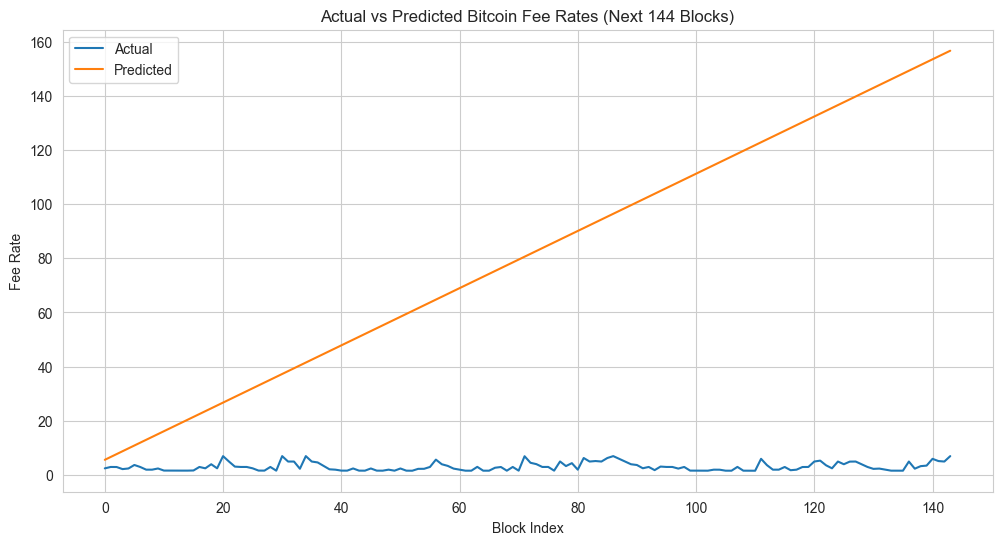


Bitcoin Fee Prediction Model Performance for Next 144 Blocks:
Mean Absolute Error: 78.0136
Mean Squared Error: 7992.9886
Root Mean Squared Error: 89.4035
R-squared Score: -3504.3494
MAPE: 2992.7110%
Directional Accuracy: 37.7622%
Theil's U Statistic: 0.9766
Training time: 3611.29s


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)
start = time.time()

# Load and preprocess data
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

df = df[:-144]

# Separate features into categories
historical_features = [
    'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
    'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_weight', 'block_interval', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity',
    'hash_rate', 'bitcoin_price_usd'
]

known_future_features = ['block_height', 'difficulty', 'block_version']

all_features = historical_features + known_future_features

# Scaling features
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df[all_features])

target = 'block_median_fee_rate'
max_encoder_length = 288  # Past 288 observations (48 hours)
max_prediction_length = 144  # Predict next 144 blocks (approximately 24 hours)

# Time2Vec layer
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x):
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

# Define custom dataset
class Time2VecDataset(Dataset):
    def __init__(self, data, historical_features, future_known_features, target, max_encoder_length, max_prediction_length):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.max_encoder_length = max_encoder_length
        self.max_prediction_length = max_prediction_length

    def __len__(self):
        return len(self.data) - self.max_encoder_length - self.max_prediction_length + 1

    def __getitem__(self, idx):
        encoder_start = idx
        encoder_end = idx + self.max_encoder_length
        decoder_end = encoder_end + self.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        # Create time feature (assuming each step is 10 minutes apart)
        time_feature = torch.arange(0, self.max_encoder_length, dtype=torch.float32).unsqueeze(1)

        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

# Create dataset and dataloaders
dataset = Time2VecDataset(df, historical_features, known_future_features, target, max_encoder_length, max_prediction_length)
batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Updated BitcoinFeeModel class with dropout
class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions, dropout_rate=0.2):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + time2vec_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_combine = nn.Linear(hidden_dim + future_input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.num_predictions = num_predictions

    def forward(self, time_feature, x_hist, x_future):
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        lstm_out, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)
        h_n = self.dropout(h_n)
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            hidden = self.dropout(hidden)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)

# Model parameters
hist_input_dim = len(historical_features)
future_known_dim = len(known_future_features)
time2vec_dim = 20
hidden_dim = 128
output_dim = 1
num_predictions = max_prediction_length
dropout_rate = 0.7 # Added dropout rate

# Instantiate model, loss function, and optimizer
model = BitcoinFeeModel(hist_input_dim, future_known_dim, time2vec_dim, hidden_dim, output_dim, num_predictions, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00028)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50  # Increased number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for time_feature, x_hist, x_future_known, y in train_dataloader:
        time_feature, x_hist, x_future_known, y = time_feature.to(device), x_hist.to(device), x_future_known.to(device), y.to(device)

        # Forward pass
        outputs = model(time_feature, x_hist, x_future_known)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Make future predictions
def predict_future(model, data, historical_features, known_future_features, max_encoder_length, max_prediction_length):
    model.eval()
    hist_data = data.tail(max_encoder_length)[historical_features].values
    last_block_height = data['block_height'].iloc[-1]
    last_difficulty = data['difficulty'].iloc[-1]
    last_block_version = data['block_version'].iloc[-1]
    
    future_known_data = np.zeros((max_prediction_length, len(known_future_features)))
    for i in range(max_prediction_length):
        future_known_data[i] = [last_block_height + i + 1, last_difficulty, last_block_version]
    
    time_feature = torch.arange(0, max_encoder_length, dtype=torch.float32).unsqueeze(1).to(device)
    x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(device)
    x_future_known = torch.tensor(future_known_data, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(time_feature, x_hist, x_future_known).cpu().numpy().flatten()

    return predictions

# Predict next 144 blocks
future_predictions = predict_future(model, df, historical_features, known_future_features, max_encoder_length, max_prediction_length)
end = time.time()

df = pd.read_csv('real_time_cleaned.csv')
# Plot results
plt.figure(figsize=(12, 6))
y_true = df[target].iloc[-max_prediction_length:].values
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(future_predictions)), future_predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 144 Blocks)')
plt.xlabel('Block Index')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(y_true, future_predictions)
mse = mean_squared_error(y_true, future_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, future_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator

mape = mean_absolute_percentage_error(y_true, future_predictions)
da = directional_accuracy(y_true, future_predictions)
theils_u = theil_u(y_true, future_predictions)

print("\nBitcoin Fee Prediction Model Performance for Next 144 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start:.2f}s")